In [ ]:
!pip install google-generativeai instaloader pillow vinted_scraper numpy pandas

In [ ]:
import google.generativeai as genai
import numpy as np
import pandas as pd
import os
import PIL.Image
import requests
import re
import argparse

from pathlib import Path
from typing import List
from collections import namedtuple
from PIL import Image
from IPython.display import display
from vinted_scraper import VintedScraper
from pandas import DataFrame

In [ ]:

os.environ["API_KEY"] = "your_api_key"
genai.configure(api_key=os.environ["API_KEY"])

In [ ]:



def load_insta_images(mypath: Path, insta_user: str) -> List:
    MyImage = namedtuple('MyImage', ['name', 'content'])
    counter = 0
    files = []
    for file in os.listdir(mypath):
        foto = MyImage(insta_user + str(counter), PIL.Image.open(os.path.join(mypath, file)))
        files.append(foto.content)
        counter +=1
    return files


def analyze_user_and_suggest(user_path: Path, user_name: str) -> str:
    model = genai.GenerativeModel("gemini-1.5-pro")
    photo_files = load_insta_images(user_path, user_name)
    prompt1 = "propose one fall outfit that follows this instagram user style. it should be a full outfit " \
              "(clothes, shoes, accessoirs). make it a list of item separated by semicolon"
    images = [prompt1] + photo_files
    response = model.generate_content(images)
    return response.text


def retrieve_photo(request: str, dataset: DataFrame) -> None:
    request_embed = genai.embed_content(model="models/text-embedding-004",
                                  content=request,
                                  task_type="retrieval_query")
    dataset['Embeddings'] = dataset['Embeddings'].apply(lambda x: [float(x) for x in x.replace("[", "").replace("]", "").split(',')])
    dot_products = np.dot(np.stack(dataset['Embeddings']), np.array(request_embed["embedding"]).reshape(-1))
    idx = np.argmax(dot_products)
    suggestion = dataset.iloc[idx]["Photo_id"]  # Return text from index with max value
    im = Image.open(suggestion)
    img_resized = im.resize((400, 450))
    display(img_resized)


def search_item_on_vinted(request: str) -> Image:
    scraper = VintedScraper("https://www.vinted.com")  # init the scraper with the baseurl
    params = {
        "search_text": request
        # Add other query parameters like the pagination and so on
    }
    items = scraper.search(params)  # get all the items
    try:
        item = items[0]
        print("Found on vinted: ", item.title)
        item_photo_url = item.photos[0].url
        item_image = Image.open(requests.get(item_photo_url, stream=True).raw)
        return item_image
    except:
        print (f"Item {request} not found on Vinted")


def show_outfit_on_vinted(outfit: List[str]) -> None:
    images = []
    for item in outfit:
        item_photo = search_item_on_vinted(item)
        if isinstance(item_photo, Image.Image):
            images.append(item_photo)
    im = images[1]
    img_resized = im.resize((400, 450))
    display(img_resized)


def gemini_describe_photo(image_path: Path) -> str:
    model = genai.GenerativeModel("gemini-1.5-flash")
    image_file = genai.upload_file(image_path)
    result = model.generate_content(
        [image_file, "\n\n", "identify the style of the outfit in the photo and describe the outfit"
                             "in as much detail as possible. use just one word for the style. "
                             "Return the output in the following format:"
                             "Outfit: <outfit style>: <outfit description>"]
    )
    print(f"{result.text=}")
    return result.text


def embed_fn(title, text):
  return genai.embed_content(model="models/text-embedding-004",
                             content=text,
                             task_type="retrieval_document",
                             title=title)["embedding"]


def parse_for_style(text: str) -> str:
    regex = '^Outfit: (\w+): (.*)$'
    action_re = re.compile(regex)
    if "*" in text:
        text = text.replace("*", '')
    actions = [
        action_re.match(a)
        for a in text.split('\n')
        if action_re.match(a)
    ]
    style, description = actions[0].groups()
    return style, description

def create_photo_dataset(photo_path: Path) -> List[dict]:
    dataset = []
    for photo_file in os.listdir(photo_path):
        photo = {}
        photo["photo_id_path"] = os.path.join(photo_path, photo_file)
        photo_descr = gemini_describe_photo(photo["photo_id_path"])
        photo["style"], photo["content"] = parse_for_style(photo_descr)
        dataset.append(photo)

    return dataset


def describe_instagram_trends(insta_photos: Path, identifier: str) -> str:
    model = genai.GenerativeModel("gemini-1.5-pro")
    photo_files = load_insta_images(insta_photos, identifier)
    prompt2 = "describe the fashion trends represented by these images. describe shapes, colors, silhouettes, accessoirs." \
              "don't describe single images, try to synthesize an overview of trends: trendy items, colors, styles, shapes."
    images = [prompt2] + photo_files
    response = model.generate_content(images)
    return response.text


def create_photo_dataframe(photos: List[dict]) -> None:
    df = pd.DataFrame(photos)
    df.columns = ['Photo_id', 'Style', 'Description']
    df['Embeddings'] = df.apply(lambda row: embed_fn(row['Style'], row['Description']), axis=1)
    df.to_csv('insta_outfit_dataset_example.csv', index=False)
    # save dataframe to disk

In [ ]:
# Photos
import random

imgExtension = ["png", "jpeg", "jpg"] #Image Extensions to be chosen from
allImages = list()

def chooseRandomImage(directory):
    for img in os.listdir(directory): #Lists all files
        ext = img.split(".")[len(img.split(".")) - 1]
        if (ext in imgExtension):
            allImages.append(img)
    choice = random.randint(0, len(allImages) - 1)
    chosenImage = allImages[choice] #Do Whatever you want with the image file
    return chosenImage


selection = "C:\\Users\\Elena\\PycharmProjects\\AI_for_Fashion\\data\\selection" # change paths for Mac and Linux
user_path = "C:\\Users\\Elena\\PycharmProjects\\AI_for_Fashion\\data\\lara_bsmnn\\selection"
photo_path = "C:\\Users\\Elena\\PycharmProjects\\AI_for_Fashion\\data\\to_suggest"
insta_dataframe = pd.read_csv('C:\\Users\\Elena\\PycharmProjects\\AI_for_Fashion\\insta_outfit_dataset.csv')





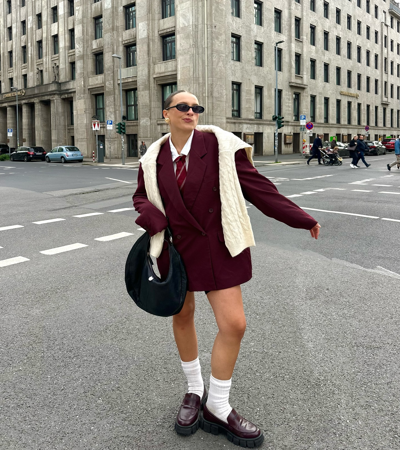

In [97]:
# random image from Lara

randomImage = chooseRandomImage(selection)
im = PIL.Image.open(os.path.join(selection, randomImage))
img_resized = im.resize((400, 450))
display(img_resized)

In [98]:
# Use case: "describe this season's instagram trends"
print(describe_instagram_trends(selection, 'insta_selection'))  # identifier is needed for photo names

These images showcase a blend of classic and contemporary trends, leaning towards a relaxed yet stylish aesthetic.  Several key themes emerge:

* **Oversized Outerwear:**  From the long black trench coat to the voluminous brown blazer and cream puffer, oversized outerwear plays a significant role. These pieces create a dramatic silhouette and offer a sense of effortless cool.  Even the tan trench coats have a relaxed fit.

* **Tailored Meets Casual:**  A juxtaposition of tailored and casual pieces is prominent.  Crisp button-down shirts are paired with suede jackets and relaxed shorts, or oversized blazers are worn with mini skirts and knee-high boots.  This blend creates a sophisticated yet approachable style.

* **Neutral and Bold Colors:**  While neutrals like beige, white, brown, and black are foundational, pops of color appear in pink sweaters, red jackets, and burgundy blazers.  This balance keeps the looks grounded while allowing for personality to shine through.

* **Wide-Leg a

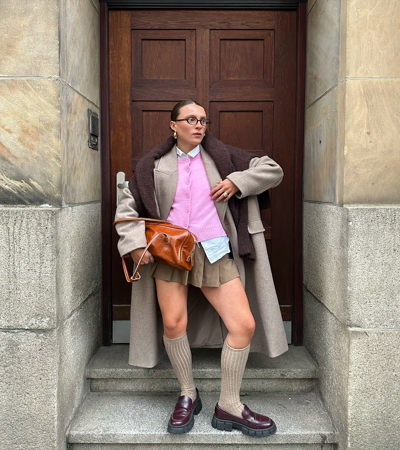

In [100]:
randomImage_LB = chooseRandomImage(user_path)

im = PIL.Image.open(os.path.join(user_path, randomImage_LB))
img_resized = im.resize((400, 450))
display(img_resized)

In [ ]:
# random image from lara bsmnn, this is what we want to recreate


# use case 2: "create me an outfit in the style of instagram influencer lara_bsmnn"
# we will get an outfit description as a suggestion from the LLM, and then we will find its components on Vinted
outfit = analyze_user_and_suggest(user_path, 'lara_bsmnn')
print(f"Suggested outfit: {outfit}")
outfit_items = outfit.split(';')

In [ ]:
show_outfit_on_vinted(outfit_items)

In [ ]:
# the photo we are going to recreate
im = PIL.Image.open(os.path.join(photo_path, 'leo_pants.jpg'))
img_resized = im.resize((400, 450))
display(img_resized)

In [ ]:
# use case 3: "recreate the look in this photo"
# this use case is similar to use case 2, but in use case 2 the outfit suggestion was based
# on analyzing multiple photos of an Instagram user, here the user just wants a specific photo to be recreated
photo_look = analyze_user_and_suggest(photo_path, 'leo_pants')
print(f"Suggested outfit: {photo_look}")
look_items = photo_look.split(';')


In [ ]:
show_outfit_on_vinted(look_items)


In [ ]:
# for the last use case, we will first create a dataset containing outfit descriptions for retrieval. 
# we will create descriptions with Gemini and embed them

insta_dataset = create_photo_dataset(selection)
create_photo_dataframe(insta_dataset)


In [ ]:
insta_dataframe = pd.read_csv('C:\\Users\\Elena\\PycharmProjects\\AI_for_Fashion\\insta_outfit_dataset.csv')

In [ ]:
# use case 4: "suggest me a trendy look with knee high boots"
request = "suggest me a trendy look with loafers"
# we will retrieve a photo from the dataframe based on photo descriptions
retrieve_photo(request, insta_dataframe)